# Projet de traitement de données massive

## Partie 1

### Collecte de données

#### Extract informations

Cloner le dataset depuis git


In [30]:
import git
# Check out via HTTPS
#git.Repo.clone_from('https://github.com/Lseig/Images_TDM.git', 'Images_git')


Extraction des informations des images


In [57]:
import PIL.Image
import os
import json
from sklearn.cluster import KMeans
import numpy
from colorthief import ColorThief
import time
import git
from IPython.display import display
from IPython.display import clear_output

from scipy.spatial import KDTree
from webcolors import hex_to_rgb
from webcolors import CSS3_HEX_TO_NAMES


class ImageAnalysis:
    def __init__(self, directory, ret_name):
        self.extract_metadata(directory)
        self.ret_name = ret_name

    def orientation(self, height, width):
        if height > width:
            return "Portrait"
        elif width > height:
            return "Paysage"
        else:
            return "Carre"
            
    def taille(self, height, width):
        if height*width >= (1200*900):
            return "Big"
        if height*width >= (500*500) and height*width < (1200*900):
            return "Medium"
        else:
            return "Small"

    def convert_rgb_to_names(self, rgb_tuple):
        # a dictionary of all the hex and their respective names in css3
        css3_db = CSS3_HEX_TO_NAMES
        names = []
        rgb_values = []
        for color_hex, color_name in css3_db.items():
            # Ajoute à la liste names les noms des couleurs
            names.append(color_name)
            rgb_values.append(hex_to_rgb(color_hex))

        kdt_db = KDTree(rgb_values)
        distance, index = kdt_db.query(rgb_tuple)
        return f'{names[index]}'

    def extract_metadata(self, directory_name):
        directory = os.fsencode(directory_name)
        dataDict = {}
        for file in os.listdir(directory):
            filename = os.fsdecode(file)
            img = PIL.Image.open(directory_name+"/"+filename)
            exif_data = img._getexif()
            color_thief = ColorThief(directory_name+"/"+filename)
            tabcolor = color_thief.get_palette(color_count=5)
            dataDict[filename] = {
                "Height": img.height,
                "Width": img.width,
                "Orientation": self.orientation(img.height, img.width),
                "Taille": self.taille(img.height, img.width),
                "Couleur dominante 1": (self.convert_rgb_to_names(tabcolor[0]), tabcolor[0]),
                "Couleur dominante 2": (self.convert_rgb_to_names(tabcolor[1]), tabcolor[1]),
                "Couleur dominante 3": (self.convert_rgb_to_names(tabcolor[2]), tabcolor[2]),
                "Couleur dominante 4": (self.convert_rgb_to_names(tabcolor[3]), tabcolor[3]),
                "Couleur dominante 5": (self.convert_rgb_to_names(tabcolor[4]), tabcolor[4])
            }

        with open(self.ret_name, 'w') as outfile:
            json.dump(dataDict, outfile)


Génération du fichier d'entrainement de l'algorithme

In [32]:
def generate_training_file(dirName, training_file, nb):
    like_dict = {}
    directory = os.fsencode(dirName)
    i = 0
    for file in os.listdir(directory):
        if i < nb:

            filename = os.fsdecode(file)
            display(PIL.Image.open(dirName+"/"+filename))
            like = input("Entrer y si vous aimez l'image" + filename +
                        " ou n si vous ne l'aimez pas")
            like_dict[filename] = {"like": like}
            clear_output(wait=True)
            i+=1
        else: break

    with open(training_file, 'w') as outfile:
        json.dump(like_dict, outfile)


Analyse du fichier d'entrainement

In [33]:
class LikeAnalysis:
    def __init__(self, training_file, image_analysis_file):
        self.training_file = training_file
        self.image_analysis_file = image_analysis_file
        self.like = []
        self.dislike = []
        self.aDict = {}
        self.concatenateLikesAnalysis()
        

    def concatenateLikesAnalysis(self):
        '''
        Concatene le fichier d'entrainement de l'algorythme avec le fichier d'analyse des données des images afin de pouvoir
        etablir les gouts des utilisateurs
        '''
        
        analysis_file = open(self.image_analysis_file, 'r')
        self.aDict = json.load(analysis_file)
        analysis_file.close()

        training_fileA = open(self.training_file)
        likeDict = json.load(training_fileA)
        training_fileA.close()

        for x in self.aDict:
            for y in likeDict:
                if x == y:
                    if likeDict[y]["like"] == "y":
                        self.like.append(self.aDict[x])
                    elif likeDict[y]["like"] == "n":
                        self.dislike.append(self.aDict[x])
        

Algorithme de recommendation

In [39]:
class suggestionAlgorithm:

    def __init__(self, AnalysisResult, image_folder):
        self.like = AnalysisResult.like
        self.dislike = AnalysisResult.dislike
        self.image_folder = image_folder
        self.aDict = AnalysisResult.aDict
        self.likeProfile = {}
        self.probaDict = {}
        self.calculateSizeLike()
        self.calculateOrientationLike()
        self.calculateColorLike()

    def calculateSizeLike(self):
        likeBig = 0
        likeSmall = 0
        likeMedium = 0

        for i in self.like:
            
            if i["Taille"] == "Big":
                likeBig += 1
            elif i["Taille"] == "Medium":
                likeMedium += 1
            elif i["Taille"] == "Small":
                likeSmall +=1

        for j in self.dislike:
            
            if j["Taille"] == "Big":
                likeBig -= 1
            elif j["Taille"] == "Medium":
                likeMedium -= 1
            elif j["Taille"] == "Small":
                likeSmall -=1
                
        self.likeProfile["Big"]= (likeBig/(1+len(self.like)+len(self.dislike)))
        self.likeProfile["Medium"]=(likeMedium/(1+len(self.like)+len(self.dislike)))
        self.likeProfile["Small"]=(likeSmall/(1+len(self.like)+len(self.dislike)))
    
    def calculateOrientationLike(self):
        likePortrait = 0
        likeLandscape = 0
        likeCarre = 0

        for i in self.like:
            if i['Orientation'] == "Portrait":
                likePortrait +=1
            elif i['Orientation'] == "Paysage":
                likeLandscape += 1
            elif i["Orientation"] == "Carre":
                likeCarre +=1
        for j in self.dislike:
            if j['Orientation'] == "Portrait":
                likePortrait -=1
            elif j['Orientation'] == "Paysage":
                likeLandscape -= 1
            elif j["Orientation"] == "Carre":
                likeCarre -=1

        self.likeProfile["Portrait"] = (likePortrait/(1+len(self.like)+len(self.dislike)))
        self.likeProfile["Paysage"] = (likeLandscape/(1+len(self.like)+len(self.dislike)))
        self.likeProfile["Carre"] = (likeCarre/(1+len(self.like)+len(self.dislike)))

    def calculateColorLike(self):
        colorLikeDict = {}
        for key in CSS3_HEX_TO_NAMES.items():
            colorLikeDict[key[1]] = 0
        for i in self.like:
            colorLikeDict[i["Couleur dominante 1"][0]] += 3/(len(self.like)+len(self.dislike))
            colorLikeDict[i["Couleur dominante 2"][0]] += 2/(len(self.like)+len(self.dislike))
            colorLikeDict[i["Couleur dominante 3"][0]] += 1/(len(self.like)+len(self.dislike))
            colorLikeDict[i["Couleur dominante 4"][0]] += 0.5/(len(self.like)+len(self.dislike))
            colorLikeDict[i["Couleur dominante 5"][0]] += 0.25/(len(self.like)+len(self.dislike))
        for j in self.dislike:
            colorLikeDict[i["Couleur dominante 1"][0]] -= 3/(len(self.like)+len(self.dislike))
            colorLikeDict[i["Couleur dominante 2"][0]] -= 2/(len(self.like)+len(self.dislike))
            colorLikeDict[i["Couleur dominante 3"][0]] -= 1/(len(self.like)+len(self.dislike))
            colorLikeDict[i["Couleur dominante 4"][0]] -= 0.5/(len(self.like)+len(self.dislike))
            colorLikeDict[i["Couleur dominante 5"][0]] -= 0.25/(len(self.like)+len(self.dislike))
        self.likeProfile["Colors"] = colorLikeDict
        
    def calculateLikeProbability(self):
        for item in self.aDict.items():
            
            probaScore = self.likeProfile[item[1]["Taille"]]+self.likeProfile[item[1]["Orientation"]]+self.likeProfile['Colors'][item[1]["Couleur dominante 1"][0]]
            self.probaDict[item[0]] = probaScore
        

    def suggestImage(self, image_name):
        if self.probaDict[image_name] > 1.5:
            return True
        else:
            return False

Test de l'algorithme

{'Big': 0.47368421052631576, 'Medium': 0.47368421052631576, 'Small': 0.0, 'Portrait': 0.7368421052631579, 'Paysage': 0.21052631578947367, 'Carre': 0.0, 'Colors': {'aliceblue': 0, 'antiquewhite': 0, 'cyan': 0, 'aquamarine': 0, 'azure': 0, 'beige': 0, 'bisque': 0.08333333333333333, 'black': 0.06944444444444445, 'blanchedalmond': 0, 'blue': 0, 'blueviolet': 0, 'brown': 0.05555555555555555, 'burlywood': 0, 'cadetblue': 0.06944444444444445, 'chartreuse': 0, 'chocolate': 0, 'coral': 0, 'cornflowerblue': 0.013888888888888888, 'cornsilk': 0, 'crimson': 0, 'darkblue': 0, 'darkcyan': 0, 'darkgoldenrod': 0, 'darkgray': 0.1527777777777778, 'darkgreen': 0, 'darkkhaki': 0.027777777777777776, 'darkmagenta': 0, 'darkolivegreen': 0.05555555555555555, 'darkorange': 0, 'darkorchid': 0, 'darkred': 0, 'darksalmon': 0, 'darkseagreen': 0, 'darkslateblue': 0.41666666666666663, 'darkslategray': 1.3333333333333333, 'darkturquoise': 0, 'darkviolet': 0, 'deeppink': 0, 'deepskyblue': 0, 'dimgray': 0.83333333333333

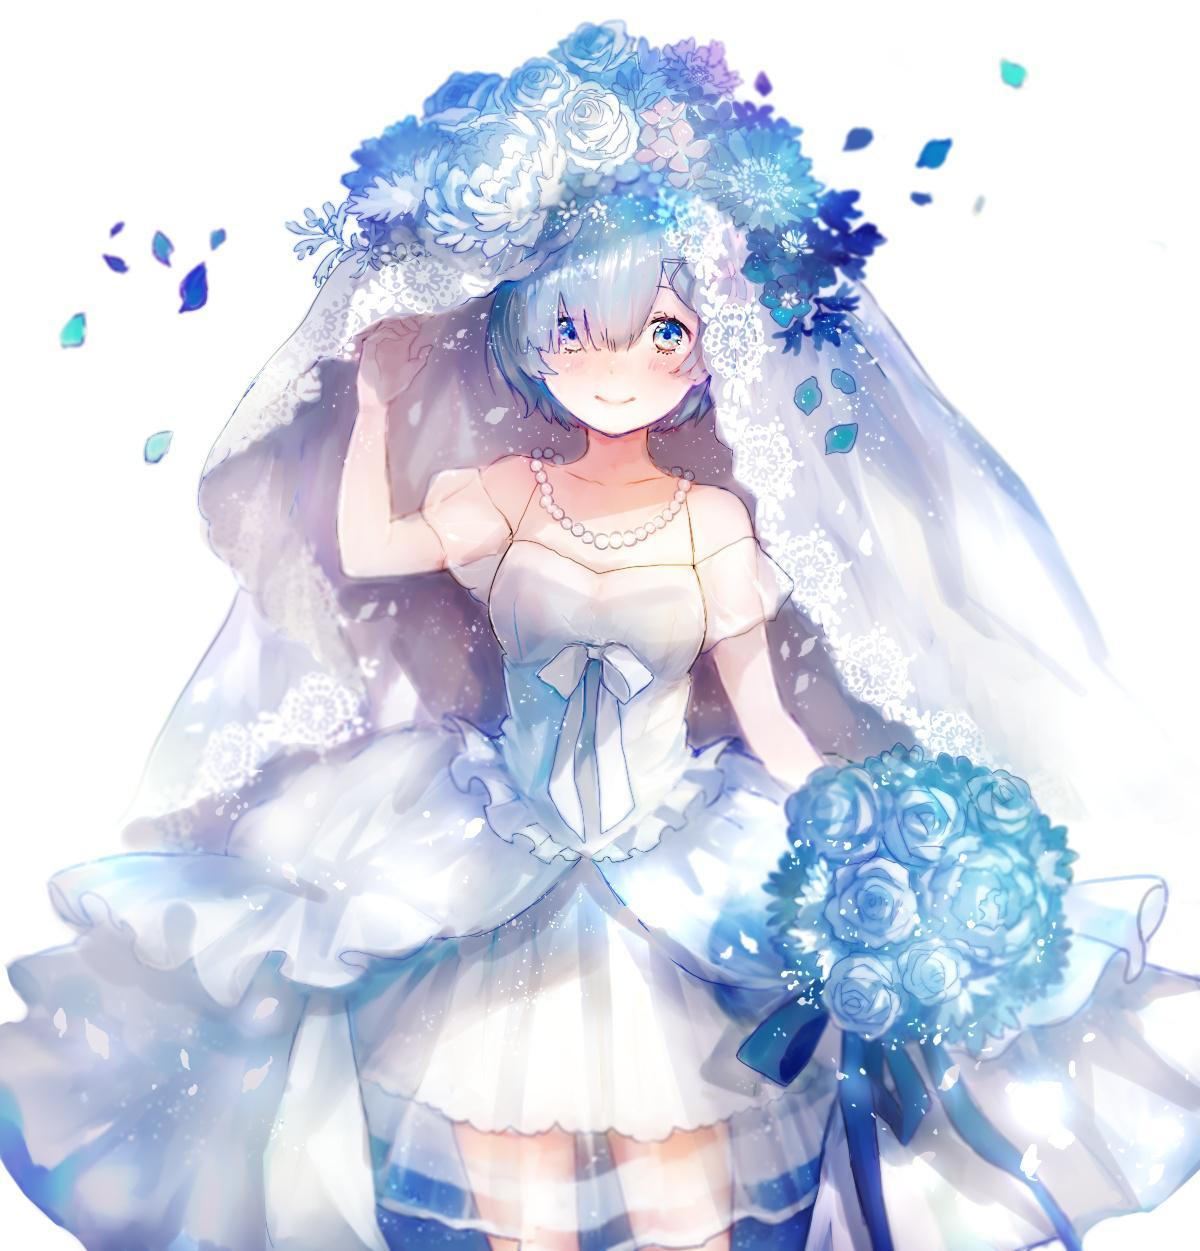

KeyboardInterrupt: Interrupted by user

In [56]:
dirName = "images"
#generate_training_file(dirName, "training_file.json", 10)
#ImageAnalysis(dirName, "json_data.json")
AnalysisResult = LikeAnalysis("training_file.json", "json_data.json")
suggestions = suggestionAlgorithm(AnalysisResult, dirName)
suggestions.calculateLikeProbability()

directory = os.fsencode(dirName)
like_dict = {}
print(suggestions.likeProfile)
i = 0
for file in os.listdir(directory):
    name = os.fsdecode(file)
    if suggestions.suggestImage(name):
        display(PIL.Image.open(dirName+"/"+name))
        like = input("Entrer y si vous aimez l'image" + name +
                        " ou n si vous ne l'aimez pas ou echap pour continuer")
        like_dict[name] = {"like": like}
        clear_output(wait=True)
        i+=1
        if i == 10:
            with open("training_file.json", 'r') as outfile:
                prev = json.load(outfile)
            for t in like_dict.items():
                prev[t[0]] = t[1]
            with open("training_file.json", 'w') as outfile:
                json.dump(prev, outfile)
            AnalysisResult = LikeAnalysis("training_file.json", "json_data.json")
            suggestions = suggestionAlgorithm(AnalysisResult, dirName)
            suggestions.calculateLikeProbability() 
            i = 0
        print(suggestions.likeProfile)